In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

In [5]:
# per_trial = pd.read_csv('/Users/Patron/Desktop/project/data/per_trial_cleaned.csv')  
# pre_study = pd.read_csv('/Users/Patron/Desktop/project/data/pre_study_cleaned.csv')  

In [6]:
# pre_study.shape

In [7]:
# per_trial.shape

In [8]:
# merged = pd.merge(per_trial, pre_study, on='participant_id', how='inner')
# merged.head()

In [9]:
merged=pd.read_csv("/Users/Patron/Desktop/project/data/data_merged.csv")

In [10]:
# Step: Define Anchoring Behavior Metric
# If model_order == A_first and preferred_model == A --> anchored
# If model_order == B_first and preferred_model == B --> anchored
merged['anchored_behavior'] = np.where(
    ((merged['model_order_encoded'] == 0) & (merged['preferred_model_encoded'] == 0)) |
    ((merged['model_order_encoded'] == 1) & (merged['preferred_model_encoded'] == 1)),
    1, 0
)

In [11]:
# Step: Define Automation Behavior Metric
# If shown_confidence_A > shown_confidence_B and preferred_model == A --> automation bias
# If shown_confidence_B > shown_confidence_A and preferred_model == B --> automation bias
merged['automation_behavior'] = np.where(
    ((merged['shown_confidence_A_numeric'] > merged['shown_confidence_B_numeric']) & (merged['preferred_model_encoded'] == 0)) |
    ((merged['shown_confidence_B_numeric'] > merged['shown_confidence_A_numeric']) & (merged['preferred_model_encoded'] == 1)),
    1, 0
)

In [12]:
def confirmation_bias(row):
    # first shown model
    first_model = 'A' if row['model_order_encoded'] == 0 else 'B'
    preferred_model = 'A' if row['preferred_model_encoded'] == 0 else 'B'
    
    if (row['first_response_confidence_rating'] < row['final_confidence_rating'] and preferred_model == first_model) or \
       (row['first_response_confidence_rating'] > row['final_confidence_rating'] and preferred_model != first_model):
        return 1
    else:
        return 0

merged['confirmation_behavior'] = merged.apply(confirmation_bias, axis=1)


In [13]:
# Step: Aggregate Behavior Per Participant
bias_behavior_summary = merged.groupby('participant_id').agg({
    'anchored_behavior': 'mean',
    'automation_behavior': 'mean',
    'confirmation_behavior': 'mean',
    'anchoring_bias': 'first',
    'automation_bias': 'first',
    'confirmation_bias': 'first'
}).reset_index()

bias_behavior_summary

,participant_id,anchored_behavior,automation_behavior,confirmation_behavior,anchoring_bias,automation_bias,confirmation_bias
0,aish,0.0,1.0,1.0,1,3,2
1,akan,1.0,0.0,0.0,3,2,4
2,akas,0.0,0.0,0.0,1,4,1
3,anan,0.0,0.0,1.0,2,2,3
4,anja,0.0,0.0,0.0,3,4,3
5,arju,1.0,0.0,0.0,2,1,2
6,ashu,1.0,1.0,0.0,1,2,1
7,jyot,0.0,0.0,0.0,3,1,2
8,kath,0.0,0.0,1.0,2,2,2
9,kesa,1.0,0.0,0.0,2,4,3


In [14]:
#Correlation analysis (Self-reported Bias vs Behavior)
correlations = {}

# Anchoring
corr_anchor, p_anchor = stats.pearsonr(bias_behavior_summary['anchoring_bias'], bias_behavior_summary['anchored_behavior'])
correlations['Anchoring'] = (corr_anchor, p_anchor)

# Automation
corr_auto, p_auto = stats.pearsonr(bias_behavior_summary['automation_bias'], bias_behavior_summary['automation_behavior'])
correlations['Automation'] = (corr_auto, p_auto)

# Confirmation
corr_confirm, p_confirm = stats.pearsonr(bias_behavior_summary['confirmation_bias'], bias_behavior_summary['confirmation_behavior'])
correlations['Confirmation'] = (corr_confirm, p_confirm)

# Display
for bias_type, (corr, pval) in correlations.items():
    print(f"{bias_type} Correlation = {corr:.3f}, p-value = {pval:.3f}")

Anchoring Correlation = 0.037, p-value = 0.857
Automation Correlation = -0.190, p-value = 0.352
Confirmation Correlation = 0.315, p-value = 0.117


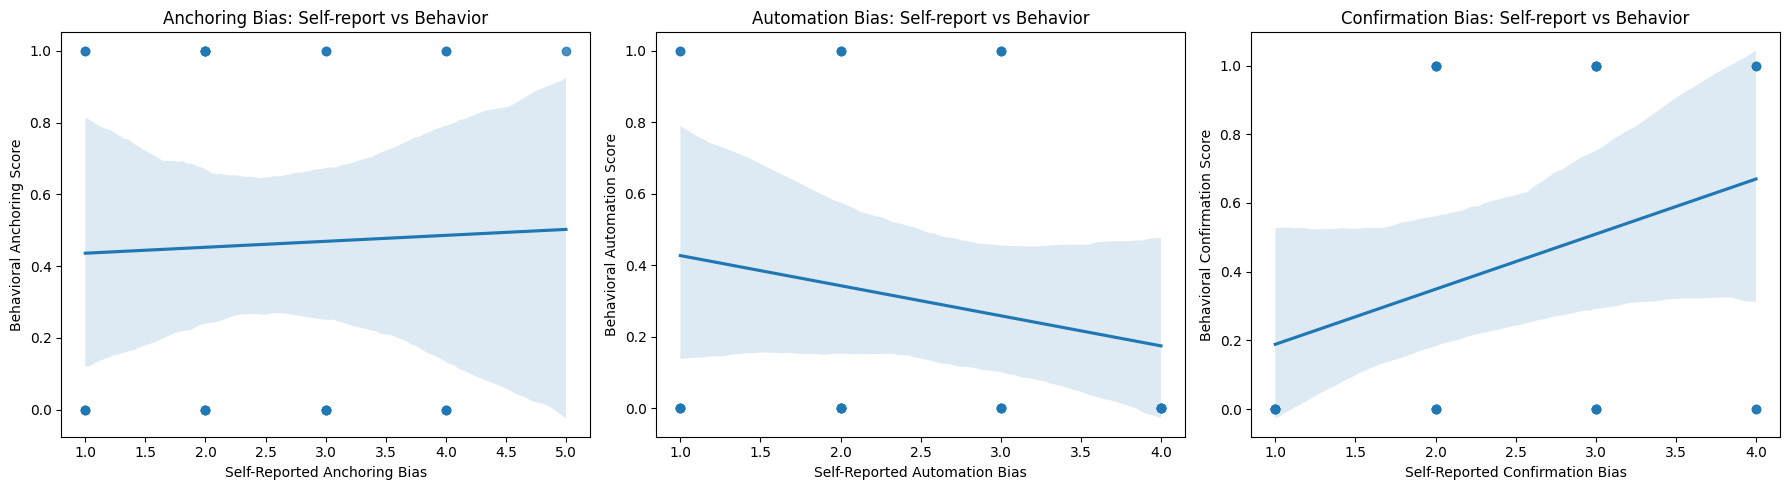

In [15]:
# Scatterplots for each Bias

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Anchoring
sns.regplot(data=bias_behavior_summary, x='anchoring_bias', y='anchored_behavior', ax=axs[0])
axs[0].set_title('Anchoring Bias: Self-report vs Behavior')
axs[0].set_xlabel('Self-Reported Anchoring Bias')
axs[0].set_ylabel('Behavioral Anchoring Score')

# Automation
sns.regplot(data=bias_behavior_summary, x='automation_bias', y='automation_behavior', ax=axs[1])
axs[1].set_title('Automation Bias: Self-report vs Behavior')
axs[1].set_xlabel('Self-Reported Automation Bias')
axs[1].set_ylabel('Behavioral Automation Score')

# Confirmation
sns.regplot(data=bias_behavior_summary, x='confirmation_bias', y='confirmation_behavior', ax=axs[2])
axs[2].set_title('Confirmation Bias: Self-report vs Behavior')
axs[2].set_xlabel('Self-Reported Confirmation Bias')
axs[2].set_ylabel('Behavioral Confirmation Score')

plt.tight_layout()
plt.show()


In [16]:
# Clean preferred model labels
merged["preferred_model_cleaned"] = merged["preferred_model"].str.strip().str.lower()

In [17]:
# Split reasoning into comment_A and comment_B using heuristic
def split_model_comments(text):
    text_lower = text.lower()
    comment_a = ""
    comment_b = ""
    
    # Patterns for A and B
    match_a = re.search(r"(model\s*a[^\.!?]*)", text_lower)
    match_b = re.search(r"(model\s*b[^\.!?]*)", text_lower)

    if match_a:
        comment_a = text[match_a.start():match_a.end()]
    if match_b:
        comment_b = text[match_b.start():match_b.end()]
    
    alt_a = re.search(r"(response\s*a[^\.!?]*)", text_lower)
    alt_b = re.search(r"(response\s*b[^\.!?]*)", text_lower)

    if not comment_a and alt_a:
        comment_a = text[alt_a.start():alt_a.end()]
    if not comment_b and alt_b:
        comment_b = text[alt_b.start():alt_b.end()]
    
    return pd.Series([comment_a.strip(), comment_b.strip()])

merged[["comment_A", "comment_B"]] = merged["trust_reasoning_text"].apply(split_model_comments)



In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# --- Sentiment Analysis Function (RoBERTa) ---
def get_sentiment(text):
    try:
        result = sentiment_pipeline(text[:512])[0]  # RoBERTa has 512-token limit
        score = result["score"]

        if score > 0.55:
            label = "Positive"
        elif score < 0.47:
            label = "Negative"
        else:
            label = "Neutral"
        
        return score, label
    except:
        return 0.0, "Neutral"

/Users/Patron/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/Patron/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-05-08 22:42:22,309] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to mps (auto detect)


[2025-05-08 22:42:22,463] torch.distributed.elastic.multiprocessing.redirects: [WARNING] NOTE: Redirects are currently not supported in Windows or MacOs.
/Users/Patron/Library/Python/3.9/lib/python/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Device set to use mps:0


In [19]:
valid_themes = {
    "Confidence Signaling and Trust Calibration": "The Clinical Authority and Specificity",
    "Concise and Goal-Oriented Communication": "The Clear and Logical Explanations",
    "Biomedical Precision and Domain Alignment": "The Clinical Authority and Specificity",
    "Excessive Reasoning or Detail": "Over-Explanation",
    "Contextual Appropriateness and Visual Grounding": "The Clear and Logical Explanations",
    "Structured Reasoning and Explanation Clarity": "The Clear and Logical Explanations"
}

# Function to infer theme from trust_reasoning_text
def infer_theme(text):
    if isinstance(text, str):
        text = text.lower()
        if "medical" in text or "accurate" in text or "research" in text:
            return "Biomedical Precision and Domain Alignment"
        elif "clear" in text or "easy" in text or "step" in text or "organized" in text:
            return "Structured Reasoning and Explanation Clarity"
        elif "short" in text or "to the point" in text or "concise" in text:
            return "Concise and Goal-Oriented Communication"
        elif "long" in text or "overwhelming" in text or "too much" in text:
            return "Excessive Reasoning or Detail"
        elif "confidence" in text or "trust" in text:
            return "Confidence Signaling and Trust Calibration"
        else:
            return "Contextual Appropriateness and Visual Grounding"
    return "Contextual Appropriateness and Visual Grounding"

# Add all theme and category columns
for col in ['themes_A', 'themes_B', 'themes_preferred', 'themes_nonpreferred']:
    merged[col] = merged['trust_reasoning_text'].apply(infer_theme)
    merged[f"{col}_category"] = merged[col].map(valid_themes)

In [20]:
# # --- Apply sentiment + theme to A and B comments ---
merged["sentiment_score_A"], merged["sentiment_label_A"] = zip(*merged["comment_A"].apply(get_sentiment))
# merged["themes_A"] = merged["comment_A"].apply(extract_themes)

merged["sentiment_score_B"], merged["sentiment_label_B"] = zip(*merged["comment_B"].apply(get_sentiment))
# merged["themes_B"] = merged["comment_B"].apply(extract_themes)



In [21]:
# --- Create preferred and non-preferred comment columns ---
merged["preferred_comment"] = merged.apply(
    lambda row: row["comment_A"] if row["preferred_model_cleaned"] == "a" else row["comment_B"], axis=1)

merged["nonpreferred_comment"] = merged.apply(
    lambda row: row["comment_B"] if row["preferred_model_cleaned"] == "a" else row["comment_A"], axis=1)

In [22]:
# # --- Apply to preferred and non-preferred ---
merged["sentiment_score_preferred"], merged["sentiment_label_preferred"] = zip(*merged["preferred_comment"].apply(get_sentiment))
# merged["themes_preferred"] = merged["preferred_comment"].apply(extract_themes)

merged["sentiment_score_nonpreferred"], merged["sentiment_label_nonpreferred"] = zip(*merged["nonpreferred_comment"].apply(get_sentiment))
# merged["themes_nonpreferred"] = merged["nonpreferred_comment"].apply(extract_themes)



In [23]:

columns_to_show = [
    "preferred_model_cleaned",
    "comment_A", "sentiment_label_A", "themes_A",
    "comment_B", "sentiment_label_B", "themes_B",
    "preferred_comment", "sentiment_label_preferred", "themes_preferred",
    "nonpreferred_comment", "sentiment_label_nonpreferred", "themes_nonpreferred"
]

# Preview result
merged[columns_to_show].head()

,preferred_model_cleaned,comment_A,sentiment_label_A,themes_A,comment_B,sentiment_label_B,themes_B,preferred_comment,sentiment_label_preferred,themes_preferred,nonpreferred_comment,sentiment_label_nonpreferred,themes_nonpreferred
0,b,"Model A highlighted quick remedies, while Mode...",Positive,Excessive Reasoning or Detail,Model B stressed long-term care,Positive,Excessive Reasoning or Detail,Model B stressed long-term care,Positive,Excessive Reasoning or Detail,"Model A highlighted quick remedies, while Mode...",Positive,Excessive Reasoning or Detail
1,b,,Negative,Confidence Signaling and Trust Calibration,model B's response improved my trust in AI,Positive,Confidence Signaling and Trust Calibration,model B's response improved my trust in AI,Positive,Confidence Signaling and Trust Calibration,,Negative,Confidence Signaling and Trust Calibration
2,b,,Negative,Concise and Goal-Oriented Communication,Model B's response was short and it also inclu...,Positive,Concise and Goal-Oriented Communication,Model B's response was short and it also inclu...,Positive,Concise and Goal-Oriented Communication,,Negative,Concise and Goal-Oriented Communication
3,a,,Negative,Confidence Signaling and Trust Calibration,,Negative,Confidence Signaling and Trust Calibration,,Negative,Confidence Signaling and Trust Calibration,,Negative,Confidence Signaling and Trust Calibration
4,a,,Negative,Contextual Appropriateness and Visual Grounding,,Negative,Contextual Appropriateness and Visual Grounding,,Negative,Contextual Appropriateness and Visual Grounding,,Negative,Contextual Appropriateness and Visual Grounding


In [24]:

columns_to_show = [
    "preferred_model_cleaned",
    "comment_A", "sentiment_label_A", "themes_A",
    "comment_B", "sentiment_label_B", "themes_B",
    "preferred_comment", "sentiment_label_preferred", "themes_preferred",
    "nonpreferred_comment", "sentiment_label_nonpreferred", "themes_nonpreferred"
]

# Preview result
merged[columns_to_show].head()

,preferred_model_cleaned,comment_A,sentiment_label_A,themes_A,comment_B,sentiment_label_B,themes_B,preferred_comment,sentiment_label_preferred,themes_preferred,nonpreferred_comment,sentiment_label_nonpreferred,themes_nonpreferred
0,b,"Model A highlighted quick remedies, while Mode...",Positive,Excessive Reasoning or Detail,Model B stressed long-term care,Positive,Excessive Reasoning or Detail,Model B stressed long-term care,Positive,Excessive Reasoning or Detail,"Model A highlighted quick remedies, while Mode...",Positive,Excessive Reasoning or Detail
1,b,,Negative,Confidence Signaling and Trust Calibration,model B's response improved my trust in AI,Positive,Confidence Signaling and Trust Calibration,model B's response improved my trust in AI,Positive,Confidence Signaling and Trust Calibration,,Negative,Confidence Signaling and Trust Calibration
2,b,,Negative,Concise and Goal-Oriented Communication,Model B's response was short and it also inclu...,Positive,Concise and Goal-Oriented Communication,Model B's response was short and it also inclu...,Positive,Concise and Goal-Oriented Communication,,Negative,Concise and Goal-Oriented Communication
3,a,,Negative,Confidence Signaling and Trust Calibration,,Negative,Confidence Signaling and Trust Calibration,,Negative,Confidence Signaling and Trust Calibration,,Negative,Confidence Signaling and Trust Calibration
4,a,,Negative,Contextual Appropriateness and Visual Grounding,,Negative,Contextual Appropriateness and Visual Grounding,,Negative,Contextual Appropriateness and Visual Grounding,,Negative,Contextual Appropriateness and Visual Grounding


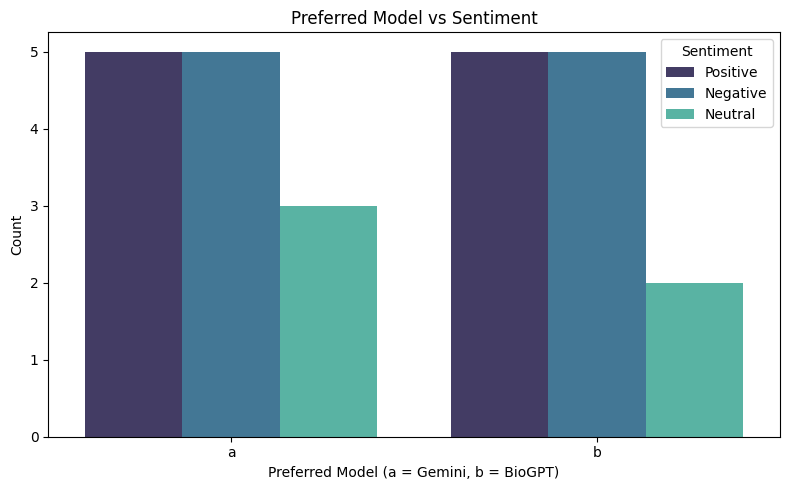

In [25]:
# Sentiment by Preferred Model (Grouped Bar)
plt.figure(figsize=(8, 5))
sns.countplot(
    data=merged,
    x="preferred_model_cleaned",
    hue="sentiment_label_preferred",
    palette="mako",
    order=["a", "b"]  # Force 'a' (Gemini) before 'b' (BioGPT)
)
plt.title("Preferred Model vs Sentiment")
plt.xlabel("Preferred Model (a = Gemini, b = BioGPT)")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


/var/folders/jn/cnxhhxhn42d2qql_g6vm7l040000gq/T/ipykernel_8271/1666803457.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


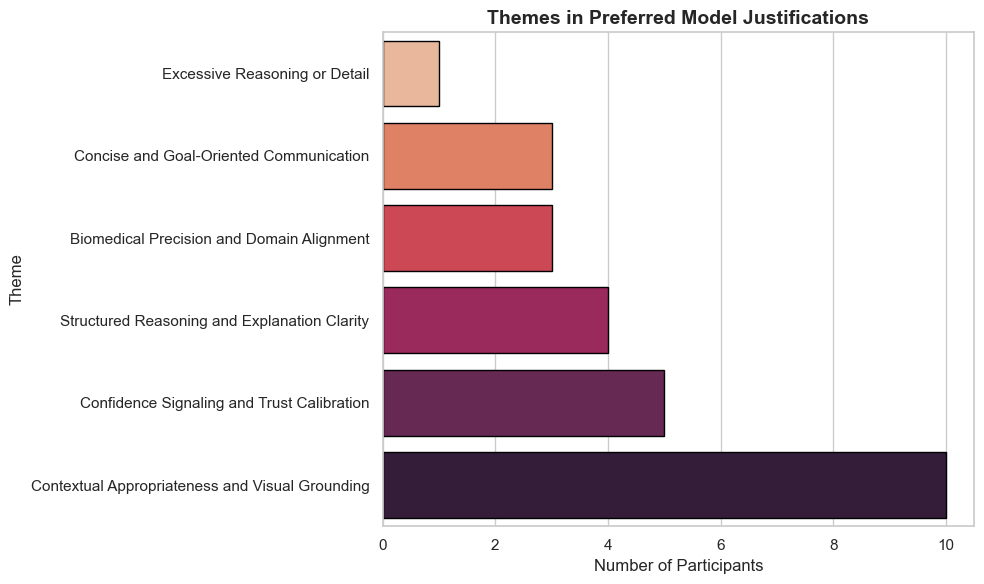

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Explode and filter out "Other"
theme_counts = (
    merged["themes_preferred"]
    .str.split(", ")
    .explode()
    .loc[lambda x: x != "Other"]
    .value_counts()
    .head(10)  # Top 10 themes
    .sort_values()
)

# Set style
sns.set(style="whitegrid")

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(
    x=theme_counts.values,
    y=theme_counts.index,
    palette="rocket_r",  # clean gradient color
    edgecolor="black"
)

plt.title("Themes in Preferred Model Justifications", fontsize=14, weight='bold')
plt.xlabel("Number of Participants")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()


In [27]:
# Split reasoning into comment_A and comment_B using heuristic
def split_model_comments(text):
    text_lower = text.lower()
    comment_a = ""
    comment_b = ""
    
    # Patterns for A and B
    match_a = re.search(r"(model\s*a[^\.!?]*)", text_lower)
    match_b = re.search(r"(model\s*b[^\.!?]*)", text_lower)

    if match_a:
        comment_a = text[match_a.start():match_a.end()]
    if match_b:
        comment_b = text[match_b.start():match_b.end()]
    
    alt_a = re.search(r"(response\s*a[^\.!?]*)", text_lower)
    alt_b = re.search(r"(response\s*b[^\.!?]*)", text_lower)

    if not comment_a and alt_a:
        comment_a = text[alt_a.start():alt_a.end()]
    if not comment_b and alt_b:
        comment_b = text[alt_b.start():alt_b.end()]
    
    return pd.Series([comment_a.strip(), comment_b.strip()])

merged[["comment_A", "comment_B"]] = merged["trust_reasoning_text"].apply(split_model_comments)



In [28]:
theme_model = merged.copy()
theme_model["themes_preferred_split"] = theme_model["themes_preferred"].str.split(", ")
exploded_theme_model = theme_model.explode("themes_preferred_split")

theme_model_ct = pd.crosstab(
    exploded_theme_model["themes_preferred_split"],
    exploded_theme_model["preferred_model_cleaned"]
).rename(columns={"a": "Gemini", "b": "BioGPT"}).sort_values(by="BioGPT", ascending=False)

print(theme_model_ct)

preferred_model_cleaned                          Gemini  BioGPT
themes_preferred_split                                         
Contextual Appropriateness and Visual Grounding       6       4
Biomedical Precision and Domain Alignment             0       3
Concise and Goal-Oriented Communication               0       2
Confidence Signaling and Trust Calibration            4       1
Excessive Reasoning or Detail                         0       1
Structured Reasoning and Explanation Clarity          3       1


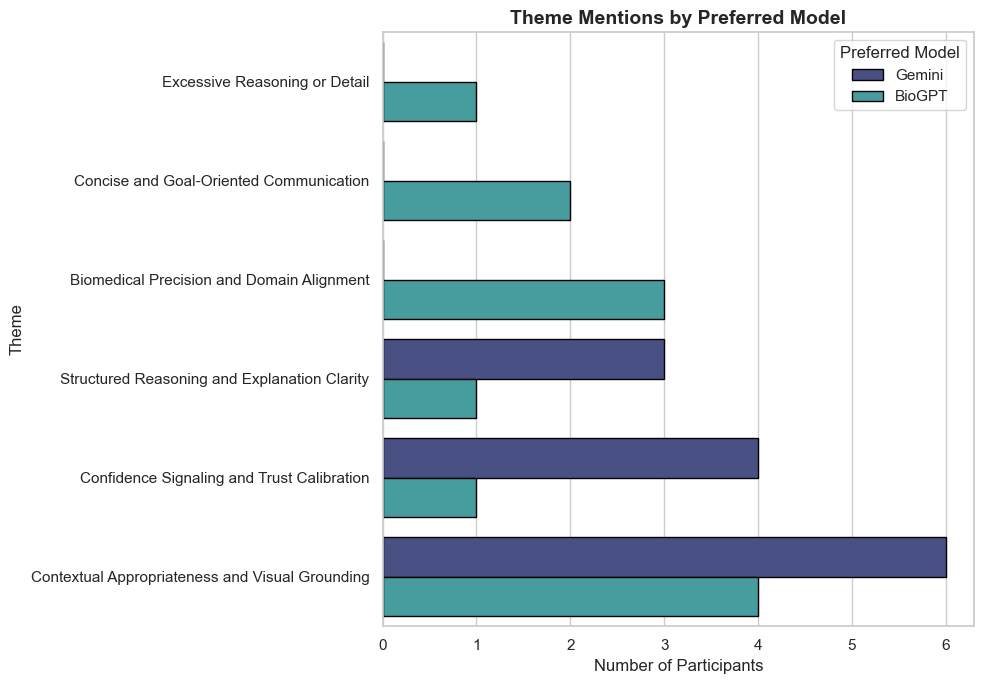

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reset index to long format
theme_plot_df = theme_model_ct.reset_index().melt(
    id_vars="themes_preferred_split",
    var_name="Preferred Model",
    value_name="Count"
)

# Sort by total count (Gemini + BioGPT)
theme_plot_df["total"] = theme_plot_df.groupby("themes_preferred_split")["Count"].transform("sum")
theme_plot_df = theme_plot_df.sort_values(by="total", ascending=True)

# Plot
plt.figure(figsize=(10, 7))
sns.barplot(
    data=theme_plot_df,
    y="themes_preferred_split",
    x="Count",
    hue="Preferred Model",
    palette="mako",
    edgecolor="black"
)

plt.title("Theme Mentions by Preferred Model", fontsize=14, weight='bold')
plt.xlabel("Number of Participants")
plt.ylabel("Theme")
plt.legend(title="Preferred Model")
plt.tight_layout()
plt.show()


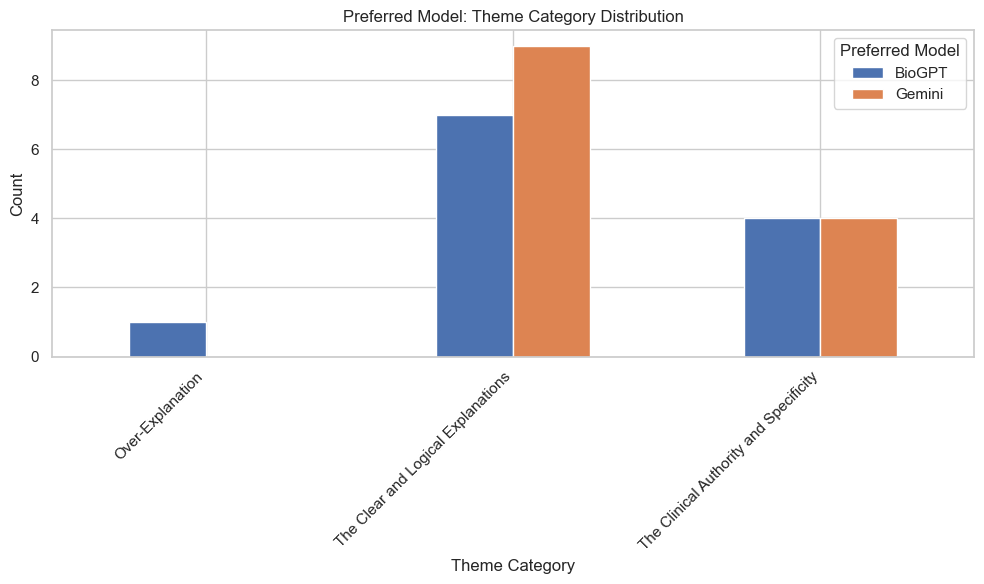

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

theme_to_category = {
    "Biomedical Precision and Domain Alignment": "The Clinical Authority and Specificity",
    "Confidence Signaling and Trust Calibration": "The Clinical Authority and Specificity",
    "Structured Reasoning and Explanation Clarity": "The Clear and Logical Explanations",
    "Concise and Goal-Oriented Communication": "The Clear and Logical Explanations",
    "Contextual Appropriateness and Visual Grounding": "The Clear and Logical Explanations",
    "Excessive Reasoning or Detail": "Over-Explanation"
}

for col in ['themes_A', 'themes_B', 'themes_preferred', 'themes_nonpreferred']:
    if f"{col}_category" not in merged.columns:
        merged[f"{col}_category"] = merged[col].map(theme_to_category)

# Function to find preferred model and theme category
def get_preferred_model_category(row):
    if row['model_order'] == "A, B" and row['preferred_model'] == 'A':
        return row['themes_A_category'], 'Gemini'
    elif row['model_order'] == "A, B" and row['preferred_model'] == 'B':
        return row['themes_B_category'], 'BioGPT'
    elif row['model_order'] == "B, A" and row['preferred_model'] == 'A':
        return row['themes_B_category'], 'Gemini'
    elif row['model_order'] == "B, A" and row['preferred_model'] == 'B':
        return row['themes_A_category'], 'BioGPT'
    else:
        return None, None

# Apply function and create two new columns
merged[['preferred_category', 'preferred_model_name']] = merged.apply(
    lambda row: pd.Series(get_preferred_model_category(row)), axis=1
)

# Count category frequencies for each preferred model
category_counts = merged.groupby('preferred_model_name')['preferred_category'].value_counts().unstack().fillna(0)

# Plot
category_counts.T.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Theme Category')
plt.ylabel('Count')
plt.title('Preferred Model: Theme Category Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title="Preferred Model")
plt.show()


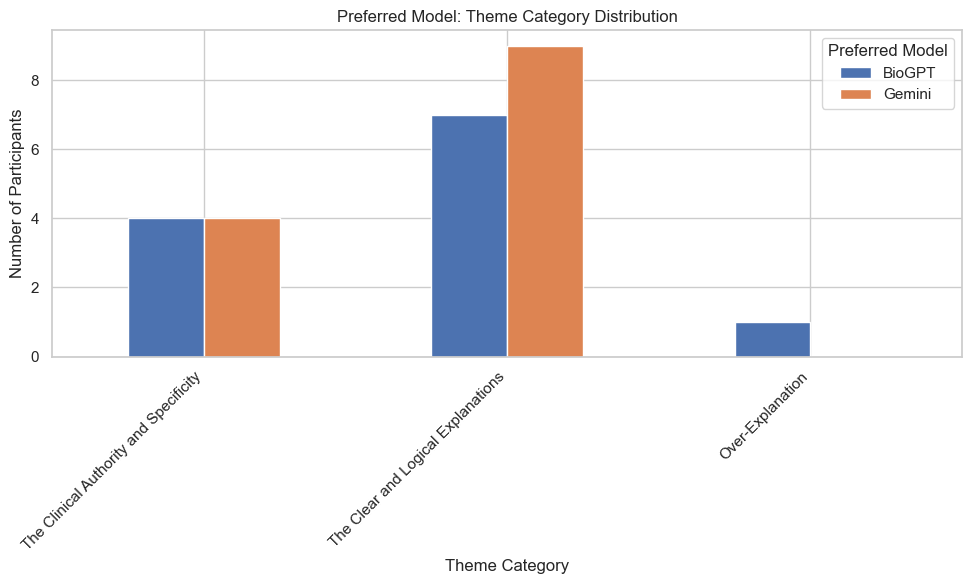

In [36]:
# Deduplicate so each participant is only counted once per theme category per model
dedup = merged[['participant_id', 'preferred_model_name', 'preferred_category']]

# Now get counts
category_counts = dedup.groupby('preferred_model_name')['preferred_category'].value_counts().unstack()

# Fix column order to match Appendix B
category_counts = category_counts[[
    'The Clinical Authority and Specificity',
    'The Clear and Logical Explanations',
    'Over-Explanation'
]]

# Plot
category_counts.T.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Theme Category')
plt.ylabel('Number of Participants')
plt.title('Preferred Model: Theme Category Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title="Preferred Model")
plt.show()


In [31]:
merged.to_csv("/Users/Patron/Desktop/project/data/data_merged.csv",index=False)